In [1]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings("ignore")

In [2]:
# Function to compute metrics
def compute_metrics(test, forecast):
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    mape = np.mean(np.abs((test - forecast) / test)) * 100
    return rmse, mae, mape

In [3]:
# Function to fit ARIMA and collect results
def evaluate_arima_model(data, column_name, p, d, q):
    try:
        # Split train-test (last 30% as test)
        split_index = int(0.7 * len(data))
        train, test = data[:split_index][column_name], data[split_index:][column_name]

        rolling_predictions = []
        current_train = train.copy()

        # Perform rolling forecast
        for test_date in test.index:
            # Fit ARIMA model on the current training set
            model = ARIMA(current_train, order=(p, d, q))
            model_fit = model.fit()

            # One-step forecast
            forecast = model_fit.forecast(steps=1)[0]
            rolling_predictions.append(forecast)

            # Update training data with the actual value
            actual_value = test[test_date]
            current_train.loc[test_date] = actual_value

        # Convert rolling predictions to a pandas Series
        rolling_predictions_series = pd.Series(rolling_predictions, index=test.index)

        # Compute metrics
        rmse, mae, mape = compute_metrics(test, rolling_predictions_series)

        # Collect model statistics
        aic = model_fit.aic
        bic = model_fit.bic

        return (p, d, q, rmse, mae, mape, aic, bic)
    except Exception as e:
        # Handle exceptions and skip non-converging models
        return (p, d, q, None, None, None, None, None)

In [4]:
# Define the grid search parameters
ar_range = range(1, 15)  # AR orders
i_range = range(0, 2)  # Differencing orders
ma_range = range(0, 15)  # MA orders

# Calculate the total number of combinations
combinations = list(itertools.product(ar_range, i_range, ma_range))
num_combinations = len(combinations)
num_combinations

In [5]:
data = pd.read_excel("C:/Users/ussrb/OneDrive - Transce3nd/Transce3nd CME File/S&P Testing/Div Yield Test/Annual Div yield.xlsx")  # Replace with your file path
data.set_index('Date', inplace=True)  # Ensure 'Date' is set as index
data.index = pd.to_datetime(data.index)  # Ensure datetime index
column_name = 'Value'

In [6]:
#Check to make sure Excel Import Worked
data

,Value
Date,
1970-01-01 00:00:00.000001871,0.0549
1970-01-01 00:00:00.000001872,0.0592
1970-01-01 00:00:00.000001873,0.0747
1970-01-01 00:00:00.000001874,0.0727
1970-01-01 00:00:00.000001875,0.0686
...,...
1970-01-01 00:00:00.000002020,0.0158
1970-01-01 00:00:00.000002021,0.0129
1970-01-01 00:00:00.000002022,0.0171


In [ ]:
# Run parallel processing for ARIMA grid search
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(evaluate_arima_model)(data, column_name, p, d, q)
    for p in ar_range for d in i_range for q in ma_range
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  6.1min


In [164]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'RMSE', 'MAE', 'MAPE', 'AIC', 'BIC'])

In [165]:
# Drop failed models (where RMSE is None)
results_df = results_df.dropna()

In [166]:
# Find the model with the lowest RMSE
if not results_df.empty:
    best_model = results_df.loc[results_df['RMSE'].idxmin()]
    print(f"Best model: ARIMA({int(best_model['p'])}, {int(best_model['d'])}, {int(best_model['q'])})")
    print(best_model)
else:
    print("No valid models were found.")

In [168]:
# Save results to Excel
results_df.to_excel("ARIMA_Grid_Search_Results2.xlsx", index=False)
print("Results saved to ARIMA_Grid_Search_Results2.xlsx")

Results saved to ARIMA_Grid_Search_Results2.xlsx


In [245]:
# Extract the column you want to model
series_data = data['Value']  # Replace 'Value' with the actual column name
print(series_data.shape)  # Verify it's a 1D series, e.g., (154,)

(154,)


In [248]:
print(data.columns)

Index(['Value'], dtype='object')


In [258]:
# Define ARIMA parameters
p, d, q = 6, 1, 4  # Adjust these based on your analysis or model selection

# Fit the ARIMA model
model = ARIMA(series_data, order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  154
Model:                 ARIMA(6, 1, 4)   Log Likelihood                 494.468
Date:                Sun, 05 Jan 2025   AIC                           -966.936
Time:                        19:30:23   BIC                           -933.601
Sample:                    01-01-1871   HQIC                          -953.395
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1470      5.228     -0.028      0.978     -10.394      10.100
ar.L2         -0.2173      0.918     -0.237      0.813      -2.017       1.582
ar.L3         -0.0370      1.483     -0.025      0.9

In [261]:
def plot_arima_forecast_with_table(data, train_size, p, d, q, forecast_steps=10, 
                                   actual_color="black", train_color="blue", test_color="orange", 
                                   test_forecast_color="green", future_forecast_color="red"):
    """
    Plot train, test, and forecasted values for an ARIMA model, and return a table of future forecasts.
    """
    # Ensure datetime index
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Split the data into train and test sets
    train, test = data[:train_size], data[train_size:]

    try:
        # Fit the ARIMA model with specified (p, d, q)
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()

        # Forecast test set
        test_forecast = model_fit.forecast(steps=len(test))
        test_forecast = pd.Series(test_forecast, index=test.index)

        # Forecast future values
        future_forecast = model_fit.forecast(steps=forecast_steps)

        # Generate future dates (annual frequency, starting from the last test date)
        last_test_date = test.index[-1]
        future_dates = pd.date_range(start=last_test_date + pd.offsets.YearEnd(), periods=forecast_steps, freq='A')

        # Align future dates with forecast values
        future_forecast_df = pd.DataFrame({
            'Date': future_dates,
            'Future Forecast': future_forecast
        })
        future_forecast_df.set_index('Date', inplace=True)

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data, label="Actual Data", color=actual_color)
        plt.plot(train.index, train, label="Training Data", color=train_color)
        plt.plot(test.index, test, label="Testing Data", color=test_color)
        plt.plot(test.index, test_forecast, label="Test Forecast", color=test_forecast_color, linestyle="--")
        plt.plot(future_dates, future_forecast, label="Future Forecast", color=future_forecast_color, linestyle=":")
        plt.title(f"ARIMA({p}, {d}, {q}) Forecast")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

        return future_forecast_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

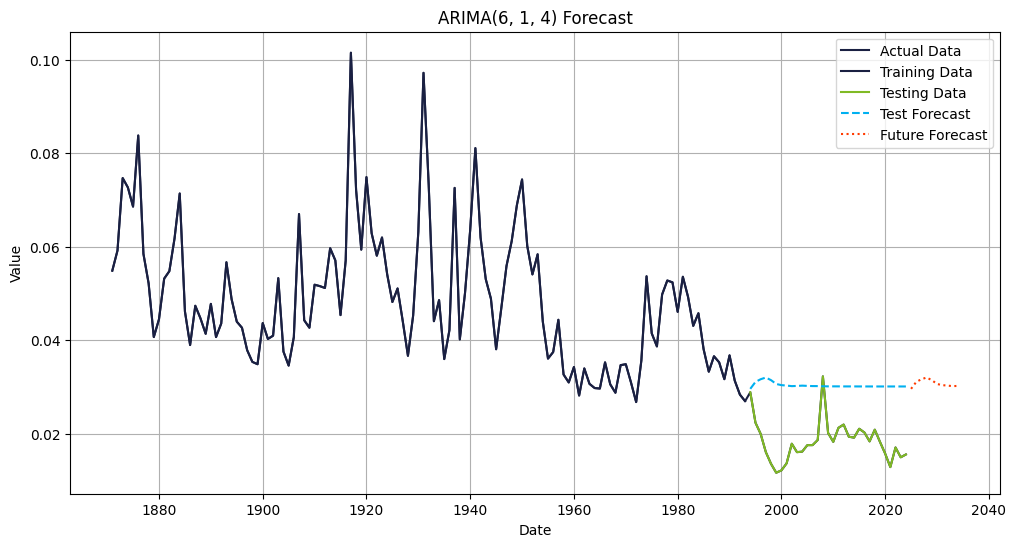

            Future Forecast
Date                       
2024-12-31         0.029637
2025-12-31         0.031117
2026-12-31         0.031688
2027-12-31         0.032053
2028-12-31         0.031488
2029-12-31         0.030677
2030-12-31         0.030425
2031-12-31         0.030334
2032-12-31         0.030213
2033-12-31         0.030257


In [263]:
# Train-test split and forecast
train_size = int(len(series_data) * 0.8)  # 70% for training
future_forecast_df = plot_arima_forecast_with_table(series_data, train_size, p=6, d=1, q=4, forecast_steps=10,
                                                    actual_color="#1A2042", train_color="#1A2042",
                                                    test_color="#80BA24", test_forecast_color="#00B0F0",
                                                    future_forecast_color="#FF3B00")

# Display the future forecast table
if future_forecast_df is not None:
    print(future_forecast_df)

In [253]:
# Assuming `fitted_model` is your ARIMA model
residuals = model_fit.resid

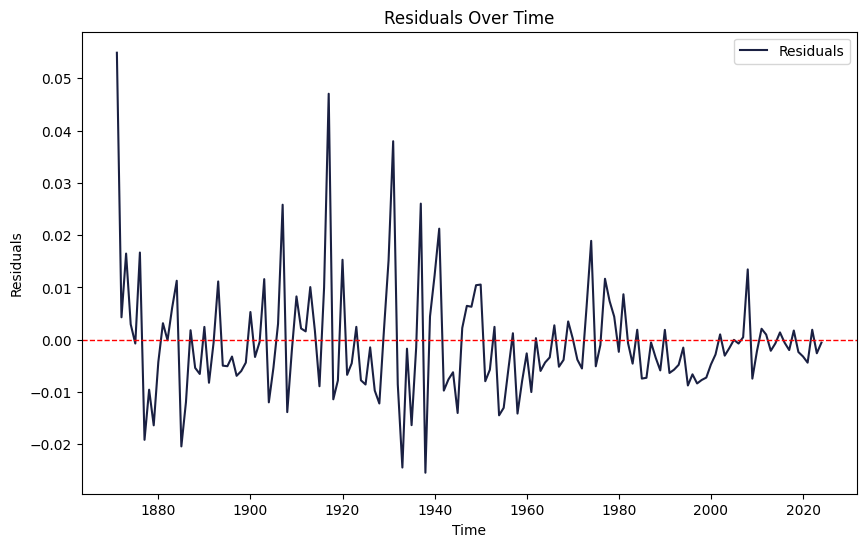

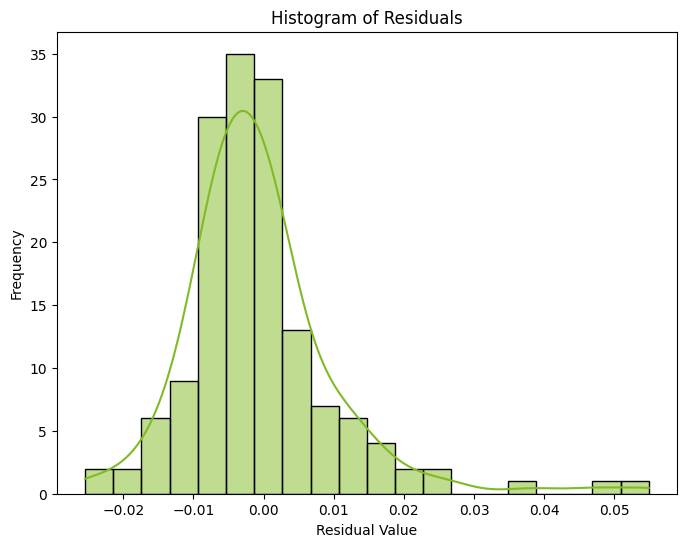

<Figure size 1000x600 with 0 Axes>

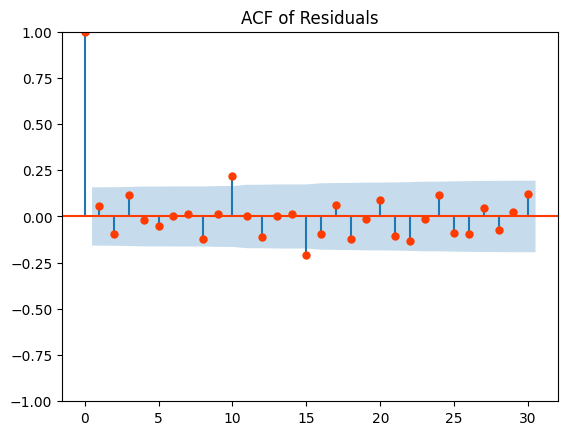

In [254]:
# Time Series Plot of Residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, color="#1A2042", label="Residuals")
plt.axhline(0, linestyle='--', color="red", linewidth=1)
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color="#80BA24", bins=20)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()

# ACF Plot of Residuals
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=30, title="ACF of Residuals", color="#FF3B00")
plt.show()